In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 4.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=ae0f4cc8c55b0b11f3382444879e6262f548eadbc9ce1a4c7a9cf9e56b0aa80a
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=fbf51614c0f53d3dd7f139131e9418a3066aa66327cb3baa967323ef70b5c5bf
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
!pip install visualkeras

     |████████████████████████████████| 798kB 6.4MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import kerastuner as kt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
train_images = np.load(r"/content/gdrive/My Drive/To Jack/train_images.npy")
test_images = np.load(r"/content/gdrive/My Drive/To Jack/test_images.npy")
train_labels = np.load(r"/content/gdrive/My Drive/To Jack/train_labels.npy")
test_labels = np.load(r"/content/gdrive/My Drive/To Jack/test_labels.npy")

In [ ]:
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

train_images = train_images[indices]
train_labels = train_labels[indices]

indices2 = np.arange(test_images.shape[0])
np.random.shuffle(indices)

test_images = test_images[indices2]
test_labels = test_labels[indices2]


In [ ]:
def show_images(images, labels, predictions, num, predict):
    """
    Visualising the images
    """
    images = np.squeeze(images)
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        if predict:
                plt.title('{} // {}'.format(predictions[i], labels[i]))
        else:
            plt.title(labels[i])
        plt.imshow(image, cmap='inferno')
        plt.axis('off')
    plt.show() 

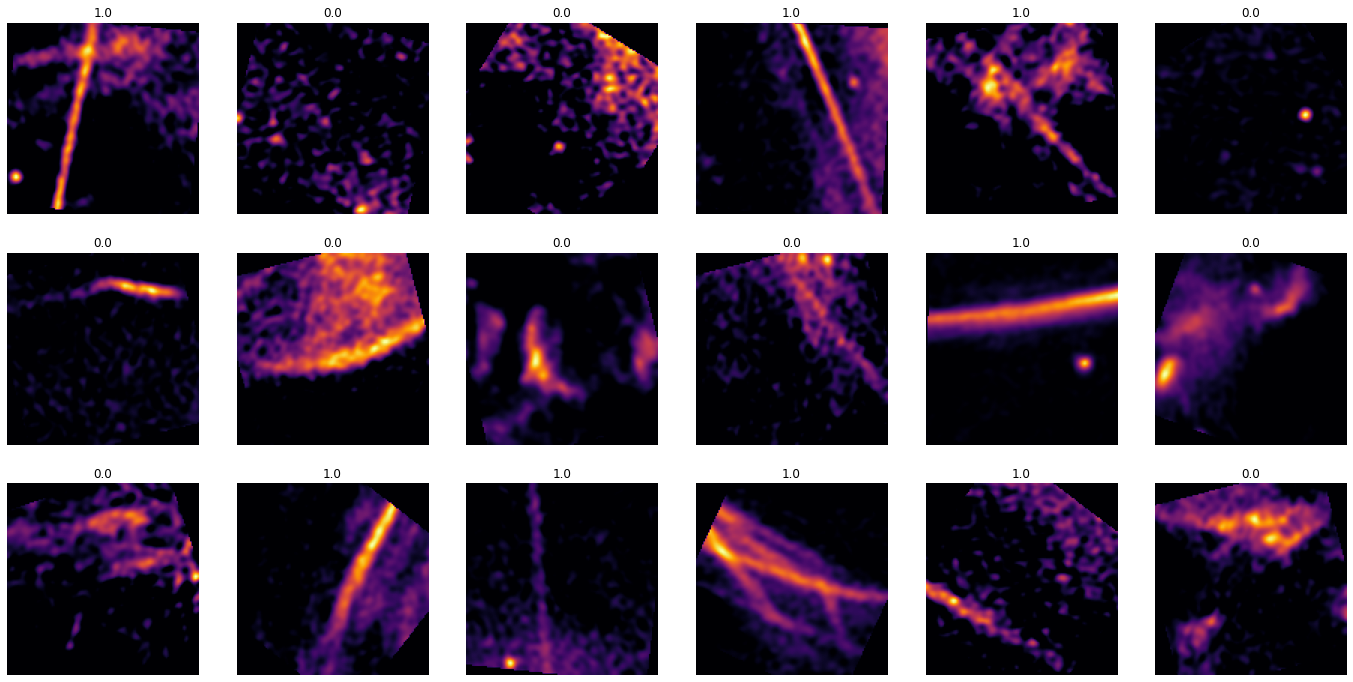

In [ ]:
show_images(train_images, train_labels,_ ,18, predict=False)

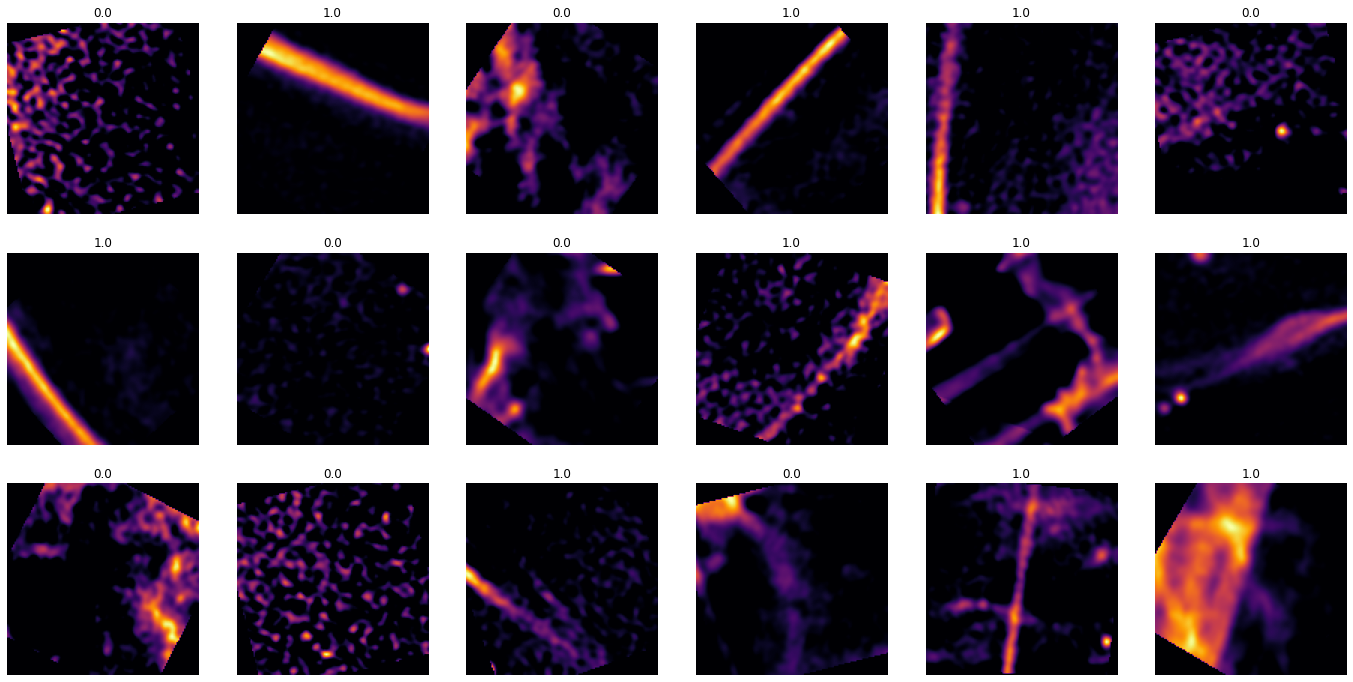

In [ ]:
show_images(test_images, test_labels,_ ,18, predict=False)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
input_shape = train_images.shape[1:]

def build_model(hp):
  inputs = tf.keras.Input(shape=input_shape)
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 7, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 512, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D((2,2))(x)
    else:
      x = tf.keras.layers.AvgPool2D((2,2))(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(hp.Int('hidden_size', 30, 512, step=10, default=50),activation='relu')(x)
  x = tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),loss='binary_crossentropy',metrics=['accuracy'])
  
  return model

In [ ]:
tuner = kt.Hyperband(build_model,objective='val_accuracy',max_epochs=50,hyperband_iterations=2, factor=3,directory='/content/gdrive/My Drive/To Jack/my_dir',project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/My Drive/To Jack/my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/gdrive/My Drive/To Jack/my_dir/intro_to_kt/tuner0.json


In [ ]:
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(train_ds.batch(batch_size), validation_data=test_ds.batch(batch_size), epochs=30,callbacks=[callback])

Trial 4 Complete [00h 04m 08s]
val_accuracy: 0.9108558893203735

Best val_accuracy So Far: 0.9782716631889343
Total elapsed time: 00h 25m 28s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |5                 |6                 
filters_0         |256               |128               
pooling_0         |avg               |max               
filters_1         |352               |416               
pooling_1         |max               |max               
filters_2         |64                |64                
pooling_2         |max               |avg               
hidden_size       |90                |310               
dropout           |0.4               |0.4               
learning_rate     |0.0047733         |0.0039985         
filters_3         |288               |448               
pooling_3         |max               |max               
filters_4         |416               |320               
pooling_4         |avg           

KeyboardInterrupt: ignored

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 128)     0     

In [ ]:
model.save(r"/content/gdrive/My Drive/To Jack/modelBlueBEAR")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/To Jack/modelBlueBEAR/assets


In [ ]:
#model.save(r"/rds/projects/s/stevenir-radio-astronomy-neural-nets/Sharif/modelBlueBEAR")